In [308]:
import json
import os
from collections.abc import Iterable
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandana as pdna
import pandas as pd
import requests

from nad.accessibility import create_network, get_accessibility_metrics
from nad.load import get_census_level, load_census, load_equip_df

In [51]:
data_path = Path(os.environ["DATA_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
segregation_path = Path(os.environ["SEGREGATION_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])
results_path = Path("./results")

# Base

## Censo

In [52]:
df_census_base = load_census(census_path / "2020" / "08.csv")
df_census_agebs = get_census_level(df_census_base, level="ageb")
df_census_blocks = get_census_level(df_census_base, level="block")

## AGEBs

In [53]:
df_geom_agebs = (
    gpd.read_file(
        population_grids_path
        / "final"
        / "zone_agebs"
        / "shaped"
        / "2020"
        / "08.2.03.gpkg",
    )
    .drop(columns=["POBTOT"])
    .set_index("CVEGEO")
)

df = df_geom_agebs.join(df_census_agebs, how="inner")

## Manzanas

In [54]:
df_geom_blocks = (
    gpd.read_file(geostatistical_framework_path / "2020" / "08_chihuahua" / "08m.shp")
    .assign(CVEGEO_AGEB=lambda x: x.CVEGEO.str[:13])
    .query("CVEGEO_AGEB in @df_geom_agebs.index")
    .set_index("CVEGEO")
    .to_crs("EPSG:6372")
)


df_blocks = df_geom_blocks.join(df_census_blocks, how="inner").assign(
    P_0A5=lambda df: df["P_0A2"] + df["P_3A5"],
)

## Equipamientos

In [55]:
df_equip = pd.concat(
    [
        load_equip_df(data_path / "datos" / "Unidad_Medica_Wgs84", name="hospitales"),
        load_equip_df(data_path / "datos" / "Guarderias", name="guarderias"),
        load_equip_df(data_path / "datos" / "PreescolarWgs84", name="preescolar"),
        load_equip_df(data_path / "datos" / "PrimariasWgs84", name="primarias"),
        load_equip_df(data_path / "datos" / "Secundarias_Wgs84", name="secundarias"),
        load_equip_df(
            data_path / "datos" / "Preparatorias_Wgs84",
            name="preparatorias",
        ),
        load_equip_df(data_path / "datos" / "Superior_Wgs84", name="superior"),
        load_equip_df(
            data_path / "datos" / "Unidad_Medica_Wgs84",
            name="unidad_medica",
        ),
    ],
    ignore_index=True,
)

# Stats

In [56]:
rows = {}

## Porcentaje población 0-5 años

In [57]:
rows["porcentaje_pob_0a5"] = (df["P_0A2"] + df["P_3A5"]) / df["POBTOT"]
rows["total_pob_0a5"] = df["P_0A2"] + df["P_3A5"]

## Porcentaje de población >60

In [58]:
rows["porcentaje_pob_60"] = df["P_60YMAS"] / df["POBTOT"]
rows["total_pob_60"] = df["P_60YMAS"]

## Porcentaje de población con menos de preparatoria terminada

In [59]:
rows["porcentaje_menos_prepa_terminada"] = 1 - df["P18YM_PB"] / df["P_18YMAS"]
rows["total_menos_prepa_terminada"] = df["P_18YMAS"] - df["P18YM_PB"]
rows["total_pob_18"] = df["P_18YMAS"]

## Ingreso

In [60]:
rows["ingreso"] = (
    gpd.read_file(segregation_path / "incomes" / "M08.04.gpkg")
    .rename(columns={"cvegeo": "CVEGEO"})
    .set_index("CVEGEO")["income_pc"]
)

In [61]:
columns = []
for key, value in rows.items():
    columns.append(value.rename(key))
out = pd.concat(columns, axis=1).join(df[["geometry"]])
out = gpd.GeoDataFrame(out, crs=df.crs, geometry="geometry")

## Equipamientos

In [62]:
temp = (
    df[["geometry"]]
    .sjoin(df_equip, how="inner", predicate="contains")
    .groupby(["CVEGEO", "equipamiento"])
    .size()
    .reset_index()
    .pivot_table(
        index="CVEGEO",
        columns="equipamiento",
        values=0,
        fill_value=0,
    )
)

for col in temp.columns:
    rows[f"num_equip_{col}"] = temp[col]

## Bienestar

In [63]:
rows["indice_bienestar"] = (
    gpd.read_file(data_path / "datos" / "bienestar.gpkg")
    .assign(CVEGEO=lambda df: df["CveGeo"])
    .set_index("CVEGEO")["NB_2020"]
    .replace(" ", np.nan)
)

## Marginacion

In [64]:
rows["indice_marginacion"] = (
    pd.read_excel(data_path / "datos" / "IMU_2020.xls", skiprows=5)
    .assign(CVEGEO=lambda df: df["CVE_AGEB"])
    .query("CVEGEO in @df.index")
    .set_index("CVEGEO")["GM_2020"]
)

## Industrias

In [407]:
with open(data_path / "datos" / "takingstock.json") as f:
    df_industry = (
        pd.DataFrame(json.load(f))
        .assign(geometry=lambda df: gpd.points_from_xy(df["Longitude"], df["Latitude"]))
        .drop(columns=["Longitude", "Latitude", "$type"])
        .set_index("ID")
    )

    df_industry = (
        gpd.GeoDataFrame(
            df_industry,
            crs="EPSG:4326",
            geometry="geometry",
        )
        .to_crs("EPSG:6372")
        .sjoin(df[["geometry"]], how="inner", predicate="within")
        .drop(columns=["CVEGEO"])
    )

In [408]:
def process_item(elem: dict) -> pd.Series:
    key = elem["Keys"][0]

    value = elem["Values"]["2023"]
    wanted_cols = [
        "TotalOnSiteReleases",
        "TotalOffSiteReleases",
    ]
    emissions = {col: value.get(col, 0) for col in wanted_cols}
    emissions["name"] = key["Name"]
    return emissions


def get_releases_complete(facility_id: int) -> pd.DataFrame:
    url = "https://takingstock.cec.org/Api/GetReport?Culture=en-US&FacilityIDs={facility_id}&IndustryLevel=4&Measure=3&PageSize=10&ReportType=16&ResultType=1&SortDirection=1&SortProperty=Keys[0].Name&Years=2023"
    response = requests.get(url.format(facility_id=facility_id), timeout=100)
    return (
        pd.DataFrame(
            [process_item(it) for it in response.json()["Items"]],
        )
        .set_index("name")
        .transpose()
        .reset_index(names="index")
        .assign(
            index=lambda df: df["index"].map(
                {
                    "TotalOnSiteReleases": "On-site releases",
                    "TotalOffSiteReleases": "Off-site releases",
                },
            ),
        )
        .set_index("index")
        .transpose()
        .query("(`On-site releases` > 0) | (`Off-site releases` > 0)")
    )


def process_chemical_types(types: Iterable[dict]):
    wanted_types = {
        "Persistent, Bioaccumulative and Toxic",
        "Known or Suspected Carcinogens",
        "Developmental/Reproductive Toxins (on California Prop 65 List)",
        "Metals",
    }
    found_types = {t["Name"].strip() for t in types}
    out = {t: t in found_types for t in wanted_types}
    out["Developmental/Reproductive Toxins"] = out.pop(
        "Developmental/Reproductive Toxins (on California Prop 65 List)",
    )
    return out


def get_chemicals_table() -> pd.DataFrame:
    url = "https://takingstock.cec.org/api/GetChemicalGroups?Culture=en-US&IndustryLevel=4&ResultType=1&Years=2023"
    out = pd.DataFrame(requests.get(url, timeout=100).json()).drop(
        columns=["$type", "TypeIds"],
    )
    chem_types = out.apply(
        lambda row: process_chemical_types(row["Types"]),
        result_type="expand",
        axis=1,
    )
    return pd.concat([out[["Name"]], chem_types], axis=1).set_index("Name")


def get_onsite_offsite_risks(
    releases: pd.DataFrame,
    chemicals: pd.DataFrame,
) -> pd.DataFrame:
    return (
        releases.reset_index()
        .melt(id_vars="name")
        .query("value > 0")
        .merge(chemicals.reset_index(names="name"), on="name", how="inner")
        .drop(columns=["name", "value"])
        .groupby("index")
        .any()
        .reindex(["On-site releases", "Off-site releases"], fill_value=False)
        .transpose()
    )


def get_total_releases(releases: pd.DataFrame) -> pd.Series:
    return releases.sum(axis=0)

In [409]:
chems = get_chemicals_table()

In [410]:
release_map = {}

for industry_id, row in df_industry.iterrows():
    releases = get_releases_complete(industry_id)
    release_map[industry_id] = {}
    release_map[industry_id]["risks"] = get_onsite_offsite_risks(
        releases,
        chems,
    ).to_dict()
    release_map[industry_id]["total_releases"] = get_total_releases(releases).to_dict()
    release_map[industry_id]["releases_by_pollutant"] = releases.to_dict()

In [411]:
with open("releases.json", "w") as f:
    json.dump(release_map, f, indent=4)

df_industry.to_crs("EPSG:4326").to_file("industry_points.geojson")

In [427]:
harmful_industries = {}
for industry_id, info in release_map.items():
    on_site_releases = info["total_releases"]["On-site releases"]
    harmful_industries[industry_id] = on_site_releases

harmful_industries = (
    pd.Series(harmful_industries, name="on_site_releases")
    .to_frame()
    .query("on_site_releases > 0")
    .join(df_industry)
    .assign(
        category=lambda df: pd.cut(
            df["on_site_releases"],
            [0, 400, 10_000, np.inf],
            labels=["Microgenerador", "Pequeño generador", "Gran generador"],
        ),
        radius=lambda df: df["category"]
        .map({"Microgenerador": 1, "Pequeño generador": 2, "Gran generador": 3})
        .astype(float),
    )
)
harmful_industries = gpd.GeoDataFrame(
    harmful_industries, crs=df_industry.crs, geometry="geometry",
).assign(
    geometry=lambda df: df["geometry"].buffer(
        df["radius"] * 1.60934 * 1000, resolution=32,
    ),
)

In [431]:
df_agebs_affected = (
    df_blocks[["geometry", "CVEGEO_AGEB", "P_0A5", "P_60YMAS", "TVIVPARHAB"]]
    .sjoin(harmful_industries[["geometry"]], how="inner", predicate="within")
    .reset_index(names="CVEGEO")
    .drop_duplicates(subset="CVEGEO")
    .groupby("CVEGEO_AGEB")
    .agg({"P_0A5": "sum", "P_60YMAS": "sum", "TVIVPARHAB": "sum"})
)

rows["infantes_vulnerables_industria"] = (
    df_agebs_affected["P_0A5"] / df["P_0A5"]
).fillna(0)
rows["adultos_mayores_vulnerables_industria"] = (
    df_agebs_affected["P_60YMAS"] / df["P_60YMAS"]
).fillna(0)
rows["viviendas_vulnerables_industria"] = (
    df_agebs_affected["TVIVPARHAB"] / df["TVIVPARHAB"]
).fillna(0)

In [432]:
df_agebs_affected

,P_0A5,P_60YMAS,TVIVPARHAB
CVEGEO_AGEB,,,
0803700011700,154.0,222.0,613.0
0803700011715,174.0,428.0,885.0
080370001172A,47.0,236.0,518.0
0803700011734,0.0,34.0,44.0
0803700011768,15.0,181.0,298.0
...,...,...,...
0803700017080,288.0,197.0,1474.0
0803700017095,385.0,164.0,1307.0
0803700017108,140.0,65.0,410.0


## Vulnerabilidad calor

In [141]:
rows["vulnerabilidad_calor"] = (
    gpd.read_file(data_path / "datos" / "GUHVI" / "agebs_GUHVI.gpkg")
    .set_index("cvegeo")["guhvi_class"]
    .astype(int)
)

## Accesibilidad

In [142]:
ADJUSTMENT_FACTOR = 3
WALK_SPEED = 5  # km/h
MAX_DISTANCE = 5_000  # aprox 1 hour of walking
NUM_POIS = 5

EQUIPAMIENTOS = {
    "guarderia": {"radius": 750},
    "preescolar": {"radius": 750},
    "primaria": {"radius": 500},
    "secundaria": {"radius": 1_000},
    "preparatoria": {"radius": 5_000},
    "universidad": {"radius": 50_000},
    "parque": {"radius": 670},
    "auditorio": {"radius": 1_000},
    "biblioteca": {"radius": 10_000},
    "cine": {"radius": 1_500},
    "unidad_deportiva": {"radius": 10_000},
    "hospital": {"radius": 50_000},
    "centro_salud": {"radius": 1_000},
}

In [ ]:
def process_gdf(path: os.PathLike) -> gpd.GeoDataFrame:
    return (
        gpd.read_file(data_path / path)
        .reset_index(drop=True)
        .filter(["geometry"])
        .to_crs("EPSG:6372")
    )


df_guarderia = process_gdf("datos/Guarderias/Guarderias.shp").assign(
    equipamiento="guarderia",
)

df_preescolar = process_gdf("datos/PreescolarWgs84/PreescolarWgs84.shp").assign(
    equipamiento="preescolar",
)

df_primaria = process_gdf("datos/PrimariasWgs84/PrimariasWgs84.shp").assign(
    equipamiento="primaria",
)

df_secundaria = process_gdf("datos/Secundarias_Wgs84/Secundarias_Wgs84.shp").assign(
    equipamiento="secundaria",
)

df_preparatoria = process_gdf(
    "datos/Preparatorias_Wgs84/Preparatorias_Wgs84.shp",
).assign(equipamiento="preparatoria")

df_universidad = process_gdf("datos/Superior_Wgs84/Superior_Wgs84.shp").assign(
    equipamiento="universidad",
)

df_parque = process_gdf("datos/pparquesWgs84/pparquesWgs84.shp").assign(
    equipamiento="parque",
)

df_auditorio = process_gdf("datos/Auditorios_Wgs84/Auditorios_Wgs84.shp").assign(
    equipamiento="auditorio",
)

df_biblioteca = process_gdf("datos/Bibliotecas/BibliotecasWgs84.shp").assign(
    equipamiento="biblioteca",
)

df_cine = process_gdf("datos/cinesWGS84/cinesWGS84.shp").assign(equipamiento="cine")

df_unidad_deportiva = process_gdf(
    "datos/Uni_DeportivasWgs84/Uni_DeportivasWgs84.shp",
).assign(equipamiento="unidad_deportiva")

In [ ]:
salud_equipamientos = {
    "CLÍNICA": "centro_salud",
    "HOSPITAL": "hospital",
    "CENTRO DE SALUD": "centro_salud",
}

df_unidad_medica = (
    gpd.read_file(
        data_path / "datos" / "Unidad_Medica_Wgs84" / "Unidad_Medica_Wgs84.shp",
    )
    .assign(equipamiento="unidad_medica")
    .reset_index(drop=True)
    .to_crs("EPSG:6372")
    .query("CATEGORIA == 'PÚBLICO'")
    .query("TIPO in ['CLÍNICA', 'HOSPITAL', 'CENTRO DE SALUD']")
    .assign(equipamiento=lambda df: df["TIPO"].map(salud_equipamientos))
    .filter(["geometry", "equipamiento"])
)

df_equipamientos = pd.concat(
    [
        df_guarderia,
        df_preescolar,
        df_primaria,
        df_secundaria,
        df_preparatoria,
        df_universidad,
        df_parque,
        df_auditorio,
        df_biblioteca,
        df_cine,
        df_unidad_deportiva,
        df_unidad_medica,
    ],
).assign(capacity=1)

df_equipamientos = gpd.GeoDataFrame(
    df_equipamientos,
    geometry="geometry",
    crs="EPSG:6372",
).assign(geometry=lambda df: df["geometry"].centroid)

df_equipamientos.head()

,geometry,equipamiento,capacity
0,POINT (2078072.038 2189348.874),guarderia,1
1,POINT (2083880.276 2181248.302),guarderia,1
2,POINT (2085036.549 2181192.865),guarderia,1
3,POINT (2081444.276 2181347.528),guarderia,1
4,POINT (2080421.538 2182165.071),guarderia,1


In [145]:
net_path = results_path / "network.h5"

if not net_path.exists():
    gdf_vialidades = gpd.read_file(
        data_path / "datos/Vialidad/VialidadWgs84.shp",
    ).to_crs(
        "EPSG:6372",
    )
    net = create_network(gdf_vialidades, results_path, MAX_DISTANCE)
else:
    net = pdna.Network.from_hdf5(net_path)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 59222
Setting CH edge vector of size 82175
Range graph removed 174 edges of 164350
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [146]:
coords = df_blocks.centroid.get_coordinates()
df_blocks_accessibility = (
    df_blocks.assign(origin_id=net.get_node_ids(coords["x"], coords["y"]))
    .reset_index()
    .set_index("origin_id")
)

In [147]:
scores = pd.DataFrame()
for nombre, item in EQUIPAMIENTOS.items():
    df_temp = df_equipamientos[df_equipamientos["equipamiento"] == nombre]
    accessibility_scores = get_accessibility_metrics(
        net,
        df_temp,
        df_blocks_accessibility["POBTOT"],
        nombre,
        MAX_DISTANCE,
        NUM_POIS,
        WALK_SPEED,
        item["radius"],
        ADJUSTMENT_FACTOR,
    )
    accessibility_scores["category"] = nombre
    scores = pd.concat([scores, accessibility_scores])

In [148]:
final_score = scores.groupby("origin_id").agg({"accessibility_score": "sum"})
results = df_blocks_accessibility.join(final_score)

df_blocks_accessibility = df_blocks_accessibility.assign(
    accessibility_score=results["accessibility_score"],
)

Q1 = df_blocks_accessibility["accessibility_score"].quantile(0)
Q3 = df_blocks_accessibility["accessibility_score"].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_blocks_accessibility = (
    df_blocks_accessibility.assign(
        accessibility_score=lambda df: df["accessibility_score"].clip(
            lower_bound,
            upper_bound,
        ),
    )
    .assign(
        accessibility_score=lambda df: (
            df["accessibility_score"] - df["accessibility_score"].min()
        )
        / (df["accessibility_score"].max() - df["accessibility_score"].min()),
    )
    .reset_index()
    .set_index("CVEGEO")
)

In [149]:
temp = df_blocks_accessibility.join(scores[["time", "category"]], on="origin_id")

parque = temp.query("category == 'parque'")
preparatoria = temp.query("category == 'preparatoria'")

manzanas_clinica_hospital = (
    temp[temp["category"].isin(["centro_salud", "hospital"])]
    .groupby("CVEGEO")
    .agg({"time": "min", "TVIVPARHAB": "sum"})
)

df_blocks_accessibility = df_blocks_accessibility.assign(
    tiempo_parque=parque["time"],
    tiempo_clinica_hospital=manzanas_clinica_hospital["time"],
    tiempo_preparatoria=preparatoria["time"],
    hogares_parque_15mi=parque[parque["time"] <= 15]["TVIVPARHAB"].fillna(0),
    hogares_clinica_hospital_30mi=manzanas_clinica_hospital[
        manzanas_clinica_hospital["time"] <= 30
    ]["TVIVPARHAB"].fillna(0),
    hogares_preparatoria_30mi=preparatoria[preparatoria["time"] <= 30][
        "TVIVPARHAB"
    ].fillna(0),
)

df_blocks_accessibility.head(5)

,origin_id,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,CVEGEO_AGEB,...,VPH_LAVAD,VPH_HMICRO,P_0A5,accessibility_score,tiempo_parque,tiempo_clinica_hospital,tiempo_preparatoria,hogares_parque_15mi,hogares_clinica_hospital_30mi,hogares_preparatoria_30mi
CVEGEO,,,,,,,,,,,,,,,,,,,,,
0803700018286011,44535,08,037,0001,8286,011,Urbana,Típica,"POLYGON ((2082431.299 2168169.073, 2082318.174...",0803700018286,...,5.0,4.0,NaN,0.045423,3.265956,34.823232,60.000000,7.0,NaN,NaN
0803700012342009,58481,08,037,0001,2342,009,Urbana,Típica,"POLYGON ((2085702.349 2182812.041, 2085696.476...",0803700012342,...,0.0,0.0,0.0,1.000000,1.336644,53.034914,27.251039,0.0,NaN,0.0
0803700012342042,21654,08,037,0001,2342,042,Urbana,Típica,"POLYGON ((2085612.952 2182637.128, 2085623.06 ...",0803700012342,...,0.0,0.0,0.0,0.331683,0.856488,60.000000,60.000000,0.0,NaN,NaN
080370001845A001,42242,08,037,0001,845A,001,Urbana,Típica,"POLYGON ((2086867.39 2171955.722, 2086786.146 ...",080370001845A,...,0.0,0.0,0.0,0.024911,4.893396,22.617636,32.349144,0.0,0.0,NaN
0803700018286003,44580,08,037,0001,8286,003,Urbana,Típica,"POLYGON ((2082405.614 2168375.778, 2082329.831...",0803700018286,...,13.0,10.0,9.0,0.039966,3.609156,35.166431,60.000000,22.0,NaN,NaN


array([[<Axes: title={'center': 'accessibility_score'}>]], dtype=object)

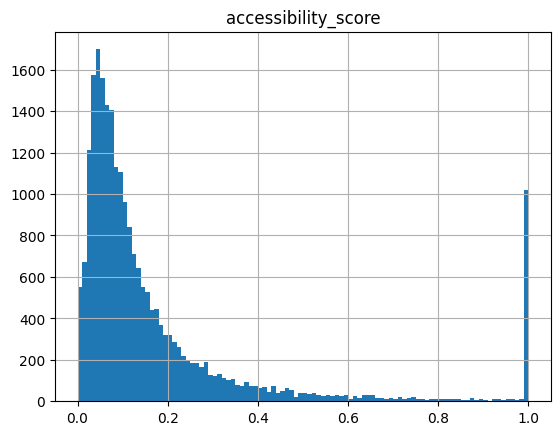

In [150]:
df_blocks_accessibility.hist(column="accessibility_score", bins=100, range=(0, 1))

<Axes: >

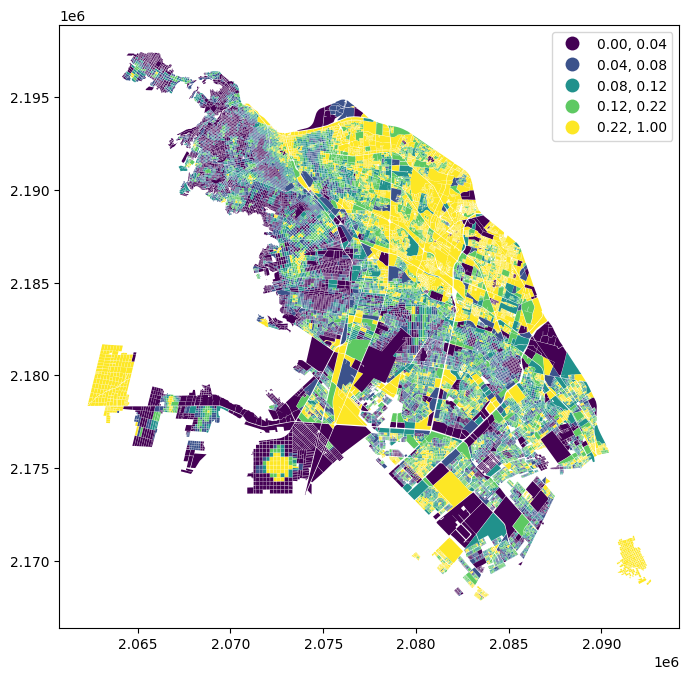

In [151]:
df_blocks_accessibility.plot(
    column="accessibility_score",
    scheme="quantiles",
    k=5,
    legend=True,
    figsize=(8, 8),
)

In [152]:
df_agebs_accessibility = (
    df_blocks_accessibility.groupby("CVEGEO_AGEB")
    .agg(
        {
            "accessibility_score": "mean",
            "tiempo_parque": "mean",
            "tiempo_clinica_hospital": "mean",
            "tiempo_preparatoria": "mean",
            "hogares_parque_15mi": "sum",
            "hogares_clinica_hospital_30mi": "sum",
            "hogares_preparatoria_30mi": "sum",
            "TVIVPARHAB": "sum",
        },
    )
    .assign(
        per_hogares_parque_15mi=lambda df: df.apply(
            lambda x: x["hogares_parque_15mi"] / x["TVIVPARHAB"]
            if x["TVIVPARHAB"] > 0
            else 0,
            axis=1,
        ).clip(0, 1),
        per_hogares_clinica_hospital_30mi=lambda df: df.apply(
            lambda x: x["hogares_clinica_hospital_30mi"] / x["TVIVPARHAB"]
            if x["TVIVPARHAB"] > 0
            else 0,
            axis=1,
        ).clip(0, 1),
        per_hogares_preparatoria_30mi=lambda df: df.apply(
            lambda x: x["hogares_preparatoria_30mi"] / x["TVIVPARHAB"]
            if x["TVIVPARHAB"] > 0
            else 0,
            axis=1,
        ).clip(0, 1),
    )
    .drop(columns=["TVIVPARHAB"])
)

for column in df_agebs_accessibility.columns:
    rows[column] = df_agebs_accessibility[column]

## Tráfico

<Axes: >

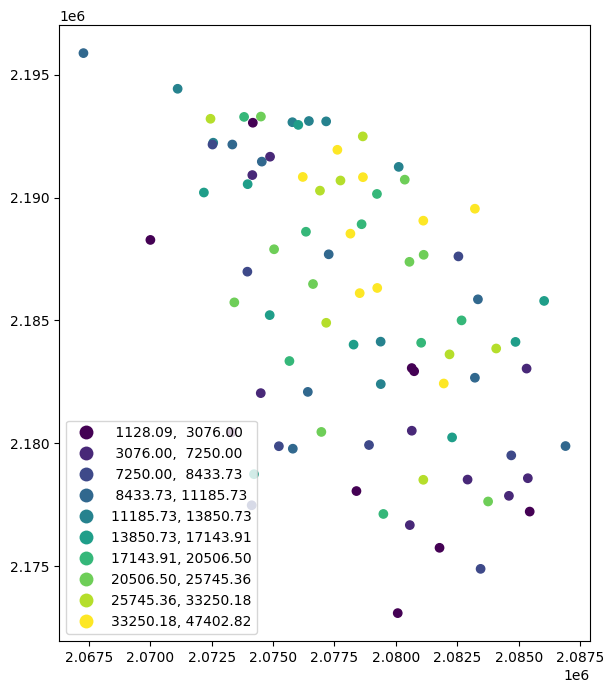

In [153]:
df_estaciones = gpd.read_file(data_path / "datos" / "aforos_vehiculares.gpkg").to_crs(
    "EPSG:6372",
)

years = [
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023",
    "2024",
]
cols = [f"TDPA_{year}" for year in years]
df_estaciones[years] = df_estaciones[cols].replace(0, np.nan)
df_estaciones["TDPA_mean"] = df_estaciones[cols].mean(axis=1)
df_estaciones.plot(
    column="TDPA_mean",
    scheme="quantiles",
    k=10,
    legend=True,
    figsize=(8, 8),
)

In [154]:
gdf_vialidades = gpd.read_file(
    data_path / "datos/SAP_Vialildad_Primaria.geojson",
).to_crs(
    "EPSG:6372",
)
gdf_vialidades = gdf_vialidades.dissolve(by=["NOMBRE_DE_"]).reset_index()

# toma el promedio del trafico vehicular de las estaciones cercanas a cada vialidad
street_mean_tdpa = (
    gpd.sjoin_nearest(
        df_estaciones[["Id", "TDPA_mean", "geometry"]],
        gdf_vialidades[["ID", "geometry"]],
        how="left",
        distance_col="dist_to_street",
        max_distance=20,
    )
    .groupby("ID")["TDPA_mean"]
    .median()
    .reset_index()
)
gdf_vialidades = gdf_vialidades.merge(street_mean_tdpa, on="ID", how="left")

<Axes: >

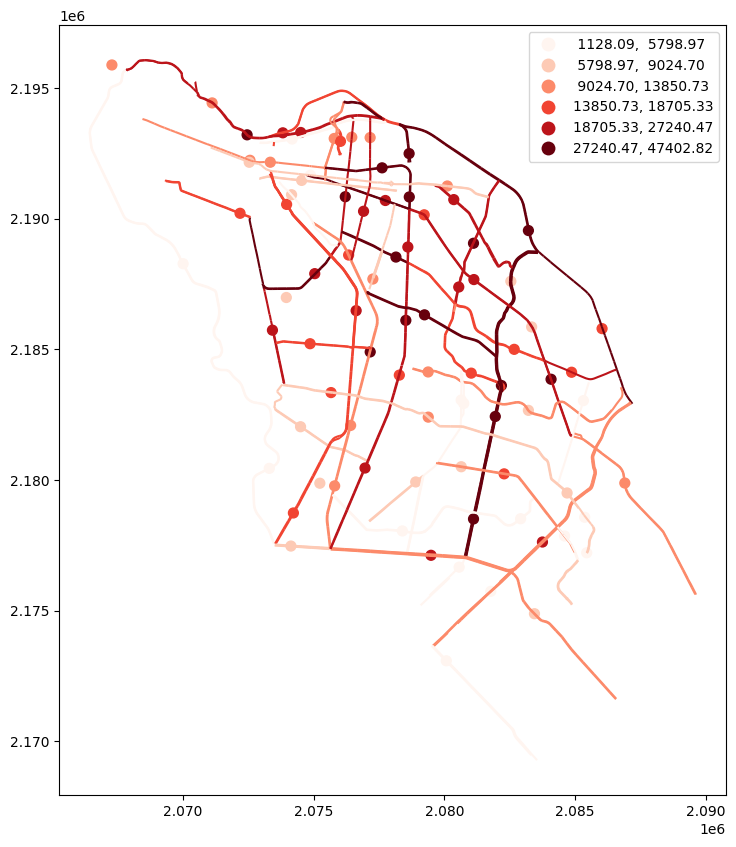

In [155]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_vialidades.plot(column="TDPA_mean", ax=ax, cmap="Reds", scheme="quantiles", k=6)
df_estaciones.plot(
    ax=ax,
    column="TDPA_mean",
    legend=True,
    cmap="Reds",
    markersize=50,
    scheme="quantiles",
    k=6,
)

In [156]:
def calculate_tdpa_exposure(
    df: gpd.GeoDataFrame,
    df_streets: gpd.GeoDataFrame,
    threshold_km: int = 500,
) -> pd.Series:
    df_temp = df.copy().reset_index()
    dist_cols = [f"distance_{row['ID']}" for index, row in df_streets.iterrows()]
    # get distance from blocks to all major streets
    df_temp[dist_cols] = df_temp.geometry.centroid.apply(
        lambda g: df_streets.geometry.distance(g),
    )

    df_temp = pd.melt(
        df_temp[["id", "geometry", *dist_cols]],
        id_vars=["id", "geometry"],
        var_name="station_id",
        value_name="distance_km",
    )
    df_temp["station_id"] = (
        df_temp["station_id"].replace({"distance_": ""}, regex=True).astype(int)
    )
    df_temp = df_temp.merge(
        df_streets[["ID", "TDPA_mean"]],
        left_on="station_id",
        right_on="ID",
        how="left",
    )

    results = {}
    for cve, group in df_temp.groupby("id"):
        close = group[group["distance_km"] <= threshold_km]

        if not close.empty:
            value = close["TDPA_mean"].sum() / threshold_km
        else:
            min_dist = group["distance_km"].min()
            closest = group[group["distance_km"] == min_dist]
            value = closest["TDPA_mean"].sum() / min_dist

        results[cve] = value

    return pd.Series(results)

In [163]:
rows["tdpa_density"] = calculate_tdpa_exposure(
    df.reset_index(names="id").set_index("id"),
    gdf_vialidades,
    threshold_km=500,
)

# Out

In [164]:
out = gpd.GeoDataFrame(
    pd.DataFrame.from_dict(rows, orient="index").transpose().join(df[["geometry"]]),
    crs=df.crs,
    geometry="geometry",
).to_crs("EPSG:4326")

for c in out.columns:
    if not c.startswith("indice") and c != "geometry":
        out[c] = out[c].astype(float)

out = out.drop(
    columns=["tiempo_viaje_hospitales", "tiempo_viaje_preparatorias"],
    errors="ignore",
)

In [ ]:
out_final = pd.concat(
    [
        out,
        pd.read_csv("./results_traffic/tdpa_agebs.csv", index_col=0).set_index("id"),
    ],
    axis=1,
)

out_final.to_file("./agebs.geojson")
out_final.drop(columns=["geometry"]).to_csv("./agebs.csv")

[26-09-2025 09:27:22] [pyogrio._io] [INFO] Created 664 records


<Axes: >

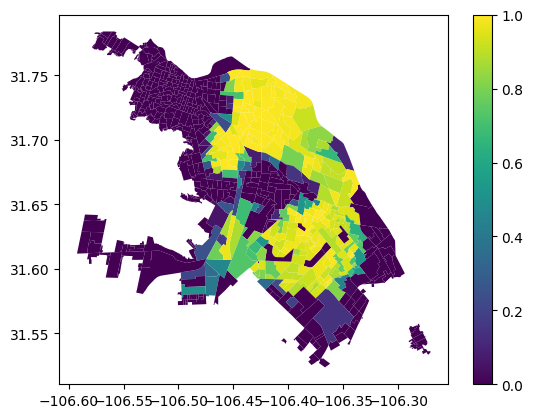

In [74]:
out.plot(column="adultos_mayores_vulnerables_industria", legend=True, categorical=False)